# Tutorial on NN
- how to interactively select your training set from image
- how to save crops
- how to load crops 
- how to featurize image
- how to train NN

### Environment setup

In [30]:
import matplotlib.pyplot as plt
import skimage.io
import skimage.feature
import skimage.future
import skimage.segmentation
import skimage.measure
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from functools import partial
import pandas as pd
import numpy as np
import czifile
import os
from scipy import ndimage

# Import the cropping widget based on ipywidgets and pillow
from interactivecrop.interactivecrop import main as crop

In [2]:
%matplotlib inline

# Make sure changes to scripts reload automatically
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/mnt/c/Users/LJUDY/OneDrive/MyStuff/Programs and Applications/LBNLPracticum/laura/scripts')

In [4]:
import visualization as viz
import explore_and_mask as eam
import metadata as meta

In [5]:
# Set parameters for plots and tables
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 14
pd.set_option("display.precision", 2)

## Read stack

In [6]:
PATH_TO_SAMPLES = '../../data/confocal_root'
%ls $PATH_TO_SAMPLES

control_1_1_O1_10x_20201120.czi*      control_3_2_O2_20x_20201120.czi*
control_1_1_O2_20x_20201120.czi*      dry_1_1_O1.2_10x_20201120.czi*
control_1_1_O2_40x_20201120.czi*      dry_1_2_O2_10x_20201120.czi*
control_1_2_O1_40x_20201120-003.czi*  dry_2_1_O2_10x_20201120.czi*
control_1_2_O2_10x_20201120.czi*      dry_2_1_O2_20x_20201120.czi*
control_1_3_H_40x_20201120.czi*       dry_2_2_O2_20x_20201120.czi*
control_1_3__40x_20201120.czi*        dry_3_1_H_40x_20201120.czi*
control_1_4_H_40x_20201120.czi*       dry_3_2_H_40x_20201120.czi*
control_1_5_O2_40x_20201120.czi*      dry_3_3_O3_40x_20201120.czi*
control_1_6_O2.3_40x_20201120.czi*    dry_3_4_O2_40x_20201120.czi*
control_2_1_O2.3_10x_20201120.czi*    dry_4_1_O2.3_40x_20201120.czi*
control_2_1_O2_40x_20201120.czi*      dry_4_2_H_40x_20201120.czi*
control_2_2_O1_10x_20201120.czi*      dry_4_3_O1_40x_20201120.czi*
control_2_2_O1_40x_20201120.czi*      gain.csv*
control_3_1_O1_20x_20201120.czi*


You can either set the file names directly based on a listing of the directory for your data files or you can use a wildcard to grab all of the file names that match a pattern, such as `.czi` in this code below.

_Note:_ Sometimes the extra `/` here will be redundant, but it avoids errors if there are is no terminating slash in the path.

In [7]:
files = ['control_1_1_O2_20x_20201120.czi','dry_2_1_O2_20x_20201120.czi']
files = [PATH_TO_SAMPLES + "/" + f for f in files]
#files = !ls $PATH_TO_SAMPLES/*.czi
#print(files)

In [8]:
# Define label and index for file
label = 'dry'
i = 1

# Read file
data = czifile.imread(files[i])

# Collapse singleton dimensions and move color axis to end
img_zyxc = np.moveaxis(np.squeeze(data), 0, -1)
print(img_zyxc.shape)

(50, 1024, 1024, 3)


Get and display the max projection of the bright-field channel

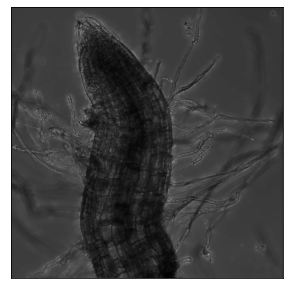

In [9]:
# Set index for bright-field channel
bf = meta.get_bf_ch_ind(files[i])

_, win = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
mp_bf = viz.get_and_show_max_proj(win, img_zyxc[:,:,:,bf])

## Get and save crop positions for foreground and background

Run the code below if you want to delete the file if it already exists and start the file fresh with only column headers `filename` and `cropDim`.

In [10]:
#%rm training.csv
#df = pd.DataFrame(columns = ['label', 'cropDim'])
#df.to_csv('training.csv', mode='w', header=True, index=False)

Define a callback function that will be called when the `Save Crop Sizes` button is selected in the `crop` interaction. We want this function to save the crop coordinates to a `csv` file.

In [11]:
def callback(image_name, shape):
    df = pd.DataFrame(columns=['label','cropDim'])
    df.loc[0,:]= image_name, shape.size
    df.to_csv('training.csv', mode='a', header=False, index=False)

Now call the [crop](https://openbits.app/posts/python-interactive-cropping/) function to get the dimensions for the training sets.

In [12]:
#crop(
#    image_list=[mp_bf, mp_bf], 
#    image_name_list=[label+'_root', label+'_background'],
#    callback=callback,
#    continuous_update=False
#)

In [13]:
%cat training.csv

label,cropDim
dry_root,"(341, 342, 217, 435)"
dry_background,"(802, 796, 222, 228)"


Capture all of the crop dimensions in a DataFrame.

In [14]:
df = pd.read_csv('training.csv')
df

,label,cropDim
0,dry_root,"(341, 342, 217, 435)"
1,dry_background,"(802, 796, 222, 228)"


Create a labeled image based on the crop dimensions.

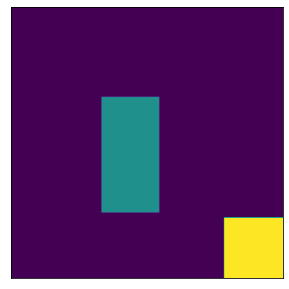

In [15]:
# Set the background to zero
training_labels = np.zeros_like(mp_bf, dtype=np.uint8)

# Increment the label for each cropped portion
for i, cropDim in enumerate(df['cropDim']):
    w, h, dw, dh = eval(cropDim)
    training_labels[h:(h+dh),w:(w+dw)] = i+1
    
# Plot
_, win = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
viz.show_plane(win, training_labels, cmap='viridis')

## Extract features

To extract the features, we will use the [`skimage.feature.multiscale_basic_features`](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.multiscale_basic_features) function. Define what features are extracted and the min and max `sigma` to use in the `partial` function definition below. 

_Note: The use of the `functools.partial` function allows us to lock in the settings for a call to extracting the features. This is not really needed for feature extraction from a single image, but it will be useful when moving to extracting features from multiple images._

In [16]:
get_features = partial(
    skimage.feature.multiscale_basic_features,
    intensity=True, edges=False, texture=True,
    sigma_min=1, sigma_max=16
)

Extract the features from the max projection

In [17]:
features = get_features(mp_bf)

## Classification with MLP

* [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) in the `sklearn.neural_network` module 
* Stands for multi-layer perceptron classifier, which means that this method uses a neural network
* `solver`:
   * `adam` works well on training time and validation score for relatively large datasets (thousands of training samples or more)
   * `lbfgs` can converge faster and perform better for smaller datasets
* The input layer is the set of image features and the output layer is the label
* The neural network is made of hidden layers between the input and output layers
* By default, there is a single hidden layer with 100 hidden nodes
* `alpha`:
    * Combats overfitting or underfitting
    * Increasing may fix high variance (sign of overfitting) by encouraging smaller weights
    * Decreasing may fix high bias (sign of underfitting) by encouraging larger weights
* `activation`:
    * The activation function defines the output of a node with a given input
    * It is a mathematical equation 
    * It determines at what level or to what extent a node at the output layer is activated
    * Only nonlinear activation functions allow the calculation of nontrivial problems
    * The `relu` activation function is $\max(0,a+\mathbf{v}^{\prime}\mathbf{b})$

In [18]:
clf = MLPClassifier( # clf is short for classifier
    random_state = 1, # Set seed for reproducing the same results
    activation = 'relu', # Activation function for the hidden layer
    solver = 'adam', # Solver for weight optimization
    alpha = 1e-4, # L2 oenalty (regularization term)
    batch_size = 200, # Size of minibatch for stochastic optimizers
    max_iter = 100 # How many times each data point will be used
)

## Train and test classifier

First, train the classifier on the labels and features

In [20]:
trained_clf = skimage.future.fit_segmenter(training_labels, features, clf)

Now use the trained classifier to predict the label for the rest of the image

In [21]:
labeled_img = skimage.future.predict_segmenter(features, trained_clf)

Visualize the results

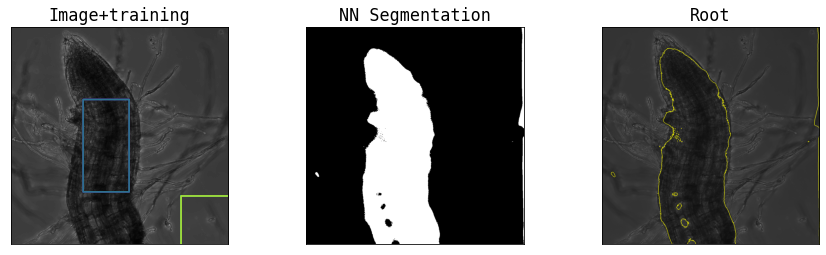

In [27]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot the bright-field max projection and the outlines of the training labels
viz.show_plane(win_left, mp_bf, title='Image+training')
win_left.contour(training_labels)

# Plot the mask from the classifier predictions
binary = labeled_img == 1 
viz.show_plane(win_center, binary, title='NN Segmentation')

# Outline the boundaries of the segmented root
boundaries = skimage.segmentation.mark_boundaries(mp_bf,labeled_img, mode='thick')
viz.show_plane(win_right, boundaries, title='Root')

Now clean up the mask 

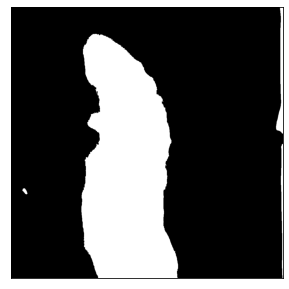

In [29]:
binary_cleaned = eam.clean_binary(binary)

_, win = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
viz.show_plane(win, binary_cleaned)

We can also select the largest object from the mask. This can only be used if the root segment is a single "object" within the image.

In [31]:
def get_largest_obj(binary):
    labels = skimage.measure.label(binary)
    largest_obj_label = np.argmax(np.bincount(labels.flat, weights=binary.flat))
    
    largest_obj = labels == largest_obj_label
    return largest_obj

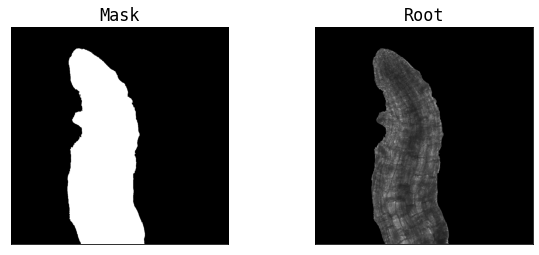

In [32]:
largest_obj_mask = get_largest_obj(binary_cleaned)

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# Plot the largest object mask
viz.show_plane(win_left, largest_obj_mask, title='Mask')

# Plot the selected root segment from the bright-field max projection
viz.show_plane(win_right, largest_obj_mask*mp_bf, title='Root')

## Use trained clf on a new images

See what the results are if we use the clf trained on this root on new images

In [33]:
files = !ls $PATH_TO_SAMPLES/*.czi

# Select the files that we want to compare
num_pairs = 3
pair_labels = ['20x', '40x', '10x']

iControl = [1, 9, 10]
iDry = [19, 25, 18]

Verify that you selected the correct files

In [34]:
file_names = [os.path.basename(f) for f in files]
control_files = []
dry_files = []
control_fnames = []
dry_fnames = []

for i in range(num_pairs):
    control_files.append(files[iControl[i]])
    dry_files.append(files[iDry[i]])
    
    control_fnames.append(file_names[iControl[i]])
    dry_fnames.append(file_names[iDry[i]])
    
compare_files = list(zip(control_fnames, dry_fnames))

df = pd.DataFrame(compare_files, columns=['Control', 'Dry'])
df

,Control,Dry
0,control_1_1_O2_20x_20201120.czi,dry_2_1_O2_20x_20201120.czi
1,control_1_6_O2.3_40x_20201120.czi,dry_4_1_O2.3_40x_20201120.czi
2,control_2_1_O2.3_10x_20201120.czi,dry_2_1_O2_10x_20201120.czi


Read in all of the stacks

In [35]:
# Read control and dry files
control_stacks = [czifile.imread(f) for f in control_files]
dry_stacks = [czifile.imread(f) for f in dry_files]

# Change dimensions to match convention
# squeeze gets rid of singleton dimensions
# moveaxis moves the color dimension to the end
for iStack in range(num_pairs):
    control_stacks[iStack] = np.moveaxis(np.squeeze(control_stacks[iStack]), 0, -1)
    dry_stacks[iStack] = np.moveaxis(np.squeeze(dry_stacks[iStack]), 0, -1)

Get the max projections of only the bright-field channel

In [38]:
control_max_proj = [np.max(stack[:,:,:,bf],axis=0) for stack in control_stacks]
dry_max_proj = [np.max(stack[:,:,:,bf],axis=0) for stack in dry_stacks]

Extract the features

In [39]:
control_features = [get_features(mp) for mp in control_max_proj]
dry_features = [get_features(mp) for mp in dry_max_proj]

Label the images based on the trained classifier

In [40]:
control_labeled = [skimage.future.predict_segmenter(feat, trained_clf) for feat in control_features]
dry_labeled = [skimage.future.predict_segmenter(feat, trained_clf) for feat in dry_features]

Select the root portion and clean

In [50]:
control_binary = [eam.clean_binary(lab==1) for lab in control_labeled]
dry_binary = [eam.clean_binary(lab==1) for lab in dry_labeled]

Plot the results

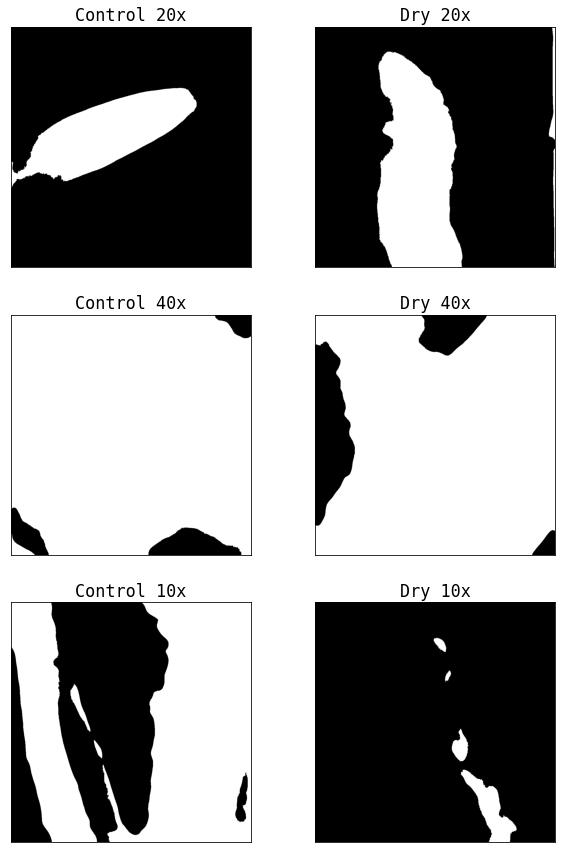

In [51]:
_, ax = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, 5*num_pairs))

for iPair in range(num_pairs):
    viz.show_plane(ax[iPair,0], control_binary[iPair], title='Control '+pair_labels[iPair])
    viz.show_plane(ax[iPair,1], dry_binary[iPair], title='Dry '+pair_labels[iPair])